---
## Setup

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'poc-example-ds'

In [2]:
LOCATION = 'europe-west1'
NOTEBOOK = '01a'


In [3]:
DATANAME = 'fraud'

# Resources
DEPLOY_COMPUTE = 'n1-standard-4'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [4]:
from google.cloud import aiplatform
from datetime import datetime

from google.cloud import bigquery
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import json
import numpy as np

clients:

In [5]:
aiplatform.init(project=PROJECT_ID, location=LOCATION)
bigquery = bigquery.Client()

parameters:

In [2]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
DIR = f"temp/{NOTEBOOK}"

NameError: name 'datetime' is not defined

environment:

In [7]:
!rm -rf {DIR}
!mkdir -p {DIR}

---
## Create Dataset (link to BigQuery table)

Vertex AI datasets are a fundamental component of Google Cloud's unified machine learning platform, Vertex AI. They serve as centralized, managed repositories for the data you use to train, evaluate, and deploy your machine learning models.
**Key Benefits of Using Vertex AI Datasets:**

* **Centralized Management:** They act as a single source of truth for your ML data, making it easier to organize, access, and control different versions of your datasets.
* **Data Labeling:** Vertex AI integrates with human labeling services, allowing you to create labels and multiple annotation sets for your data, which is crucial for supervised learning tasks.
* **Lineage Tracking:** Datasets are linked to the models trained on them, providing valuable lineage for governance, auditing, and iterative development. You can see which dataset version was used to train a specific model.
* **Automated Data Preparation:** Vertex AI can automatically handle certain data preprocessing tasks like data cleaning, normalization, and splitting data into training, validation, and test sets, especially for AutoML.
* **Data Statistics and Visualizations:** You can generate statistics and visualizations of your data to gain insights into its distribution, missing values, and other important characteristics.
* **Flexibility for Training:** You can use Vertex AI datasets with both AutoML (for low-code/no-code model training) and custom training jobs (where you provide your own training code).


**Types of Data Supported:**
Vertex AI datasets are designed to handle various data types commonly used in machine learning:
- 🧑‍🎓 **Tabular Datasets**: Structured data organized in rows and columns (e.g., CSV files, BigQuery tables). Used for tasks like classification, regression, and forecasting.
- **Image Datasets**: Collections of images for tasks such as image classification, object detection, and image segmentation.
- **Text Datasets**: Written text for natural language processing (NLP) tasks like text classification, sentiment analysis, and entity extraction.
- **Video Datasets**: Videos for tasks like video classification, action recognition, and object tracking.

 

**How Vertex AI Datasets Work:**

1.  **Data Ingestion:** You import your raw data into a Vertex AI dataset. This data can reside in Google Cloud Storage buckets or BigQuery tables. Vertex AI datasets primarily reference your original data; they don't necessarily duplicate it.
2.  **Schema Definition:** You define a schema for your dataset, specifying data types for each column (for tabular data) or the structure of your unstructured data. This ensures consistency and helps Vertex AI understand your data.
3.  **Labeling (Optional but Recommended):** For supervised learning, you'll often need to label your data. Vertex AI provides tools for manual labeling or integration with human labeling services.
4.  **Data Splitting:** Vertex AI can automatically split your dataset into training, validation, and test sets. This is essential for evaluating your model's performance on unseen data.
5.  **Integration with Training:** When you train a model in Vertex AI (either with AutoML or custom training), you specify the Vertex AI dataset to use. Vertex AI passes metadata about the dataset to your training application, often through environment variables, indicating the location of the training, validation, and test data.
6.  **Version Control:** Vertex AI datasets support versioning, allowing you to keep track of changes to your data over time and retrain models on previous data states if needed. This is crucial for MLOps practices.

In essence, Vertex AI datasets provide a robust and managed way to prepare, organize, and integrate your data into the machine learning workflow on Google Cloud, ultimately simplifying and accelerating the development of high-quality AI models.




In [8]:
dataset = aiplatform.TabularDataset.create(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}', 
    bq_source = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
    labels = {'notebook':f'{NOTEBOOK}'}
)

Creating TabularDataset
Create TabularDataset backing LRO: projects/902912982096/locations/europe-west1/datasets/2865419660960989184/operations/8995240691399393280
TabularDataset created. Resource name: projects/902912982096/locations/europe-west1/datasets/2865419660960989184
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/902912982096/locations/europe-west1/datasets/2865419660960989184')


**Dataset link:** https://console.cloud.google.com/vertex-ai/locations/europe-west1/datasets/2865419660960989184/analyze?inv=1&invt=Ab39Iw&project=poc-example-ds

if you click on each class you can see statistics on them. For example we can notice the Target Class (i.e. Class) is unbalanced: 
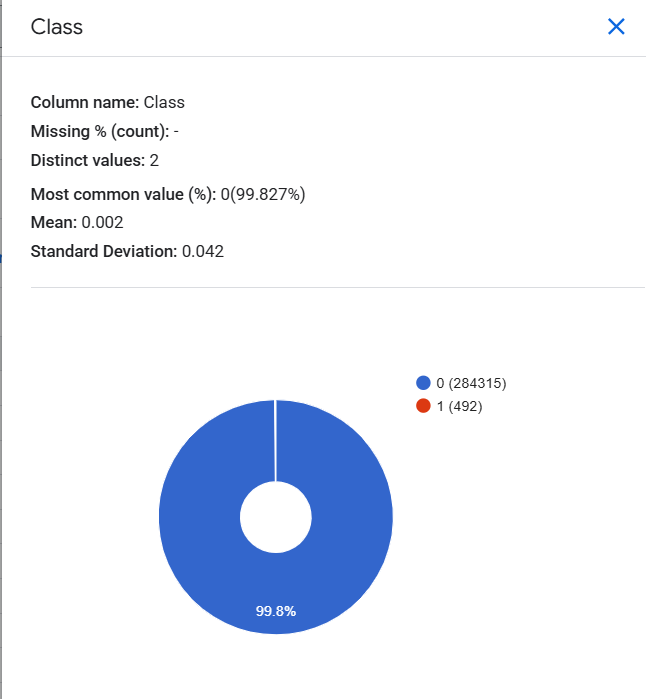

---
## Train Model with AutoML

In [9]:
# prepare a dictionary of column specifications for a machine learning task

# Identifies relevant input features: It starts with all columns in a dataset and removes columns that are:
# - Explicitly marked for omission (VAR_OMIT).
# - The target variable (VAR_TARGET).
column_specs = list(set(dataset.column_names) - set(VAR_OMIT.split()) - set([VAR_TARGET, 'splits']))

#  Creates a specification dictionary which automatically infer the data type
column_specs = dict.fromkeys(column_specs, 'auto')

Define a Job:
- Consider Weighting
- Model Type
- Optimization Objective

https://googleapis.dev/python/aiplatform/latest/aiplatform.html#google.cloud.aiplatform.AutoMLTabularTrainingJob

In [11]:
tabular_classification_job = aiplatform.AutoMLTabularTrainingJob(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    optimization_prediction_type = 'classification', # Train a classification model using tabular data.
    optimization_objective = 'maximize-au-prc', # Optimize the model to maximize the Area Under the Precision-Recall Curve,since imbalanced classes.
    column_specs = column_specs,
    labels = {'notebook':f'{NOTEBOOK}'}
)

In [ ]:
# initiates the execution of the AutoML Tabular Classification 
# Training Job that was defined in the previous step.
model = tabular_classification_job.run(
    dataset = dataset,
    target_column = VAR_TARGET,
    predefined_split_column_name = 'splits',
    #    training_fraction_split = 0.8,
    #    validation_fraction_split = 0.1,
    #    test_fraction_split = 0.1,
    budget_milli_node_hours = 1000,
    model_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    disable_early_stopping = False,
    model_labels = {'notebook':f'{NOTEBOOK}'}
)

View Training:
https://console.cloud.google.com/ai/platform/locations/europe-west1/training/2419500144652189696?project=902912982096
AutoMLTabularTrainingJob projects/902912982096/locations/europe-west1/trainingPipelines/2419500144652189696 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/902912982096/locations/europe-west1/trainingPipelines/2419500144652189696 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/902912982096/locations/europe-west1/trainingPipelines/2419500144652189696 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/902912982096/locations/europe-west1/trainingPipelines/2419500144652189696 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/902912982096/locations/europe-west1/trainingPipelines/2419500144652189696 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/902912982096/locations/europe-wes

**Notice:**
* **`predefined_split_column_name = 'splits'`**:
    * **`predefined_split_column_name`**: This parameter indicates that your `dataset` contains a specific column that defines how the data should be split into training, validation, and test sets.
    * **`'splits'`**: This specifies that the column named `'splits'` in your dataset (which was explicitly excluded from `column_specs` in the previous step) will be used for this purpose. This column typically contains values (e.g., 'TRAIN', 'VALIDATE', 'TEST') that AutoML interprets to partition the data.
    * **Purpose**: This gives you precise control over your data splits, which is often preferred over random splits, especially if you have time-series data or want to ensure specific data characteristics are maintained in each split.

* **`# training_fraction_split = 0.8,`**
* **`# validation_fraction_split = 0.1,`**
* **`# test_fraction_split = 0.1,`**
    * These lines are commented out, meaning they are not active in this specific execution.
    * **If they *were* active**: These parameters would tell AutoML to automatically split your dataset into training (80%), validation (10%), and test (10%) sets randomly.
    * **Purpose of commenting out**: By commenting them out and using `predefined_split_column_name`, you are explicitly choosing to use your own predefined splits rather than letting AutoML do a random split. This is often a better practice for reproducibility and to avoid data leakage if splits are based on business logic.

* **`budget_milli_node_hours = 1000`**:
    * **`budget_milli_node_hours`**: This is a critical cost-control parameter. It sets the maximum training time (and thus the maximum cost) for your AutoML job.
    * **`1000`**: This value means 1000 milli-node hours, which translates to **1 node hour**.
        * 1 node hour = 1,000 milli-node hours.
        * For example, if the job uses 1 node for 1 hour, it consumes 1 node hour. If it uses 0.5 nodes for 2 hours, it's still 1 node hour.
    * AutoML will train various models and configurations within this budget. It will stop once it finds a satisfactory model or when the budget is reached, whichever comes first.
    * **Purpose**: To manage the computational resources and costs associated with the AutoML training process.

* **`model_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}'`**:
    * **`model_display_name`**: This provides a human-readable name for the *resulting trained model* that will be registered in the Vertex AI Model Registry.
    * **`f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}'`**: Similar to the job display name, this f-string creates a unique and descriptive name for the model.
    * **Purpose**: Makes it easy to identify the trained model in the Vertex AI console after the training job completes.

* **`disable_early_stopping = False`**:
    * **`disable_early_stopping`**: This boolean parameter controls whether AutoML should stop training a particular model configuration early if it's not showing significant improvement on the validation set.
    * **`False`**: By setting it to `False`, you are enabling early stopping. This means AutoML will intelligently stop unpromising trials, which helps save compute budget and avoid overfitting.
    * **Purpose**: To optimize resource usage and potentially improve model generalization by preventing excessive training.
 

---
## Evaluation
While the model above was trained using AutoML with the API, it is still possible to review the evaluation metrics directly in the Google Cloud Console.  Just visit the Models section of Vertex AI service and select the model and it will present the evaluation metrics with many helpful visuals.

It is also possible to retrieve the evaluation metrics for you model using the API.  This section shows how to use the API.


Setup a model client for the model create by this notebook:

In [28]:
model.resource_name

'projects/902912982096/locations/europe-west1/models/3164460435436994560'

In [29]:
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {
        'api_endpoint' : f'{LOCATION}-aiplatform.googleapis.com'
    }
)

Retrives the aggregate model evalution metrics for the model as a whole.  First, use `.list_model_evaluations` to retrieve the evaluation id, then use `.get_model_evaluation` for the evaluation id:

In [30]:
evaluations = model_client.list_model_evaluations(parent = model.resource_name)
evals = iter(evaluations)
eval_id = next(evals).name
geteval = model_client.get_model_evaluation(name = eval_id)

Review several of the metrics include in the evaluation.  Also, compare these to the results in the console view.

In [31]:
geteval.metrics['auPrc']

0.99986047

In [32]:
for i in range(len(geteval.metrics['confusionMatrix']['annotationSpecs'])):
    print('True Label = ', geteval.metrics['confusionMatrix']['annotationSpecs'][i]['displayName'], ' has Predicted labels = ', geteval.metrics['confusionMatrix']['rows'][i])

True Label =  0  has Predicted labels =  [28426.0, 0.0, 0.0]
True Label =  1  has Predicted labels =  [10.0, 45.0, 0.0]
True Label =  DROPPED  has Predicted labels =  [0.0, 0.0, 0.0]


For models with labels you can retrieve the evaluation metrics for each slice of the model:

In [33]:
slices = model_client.list_model_evaluation_slices(parent = eval_id)

In [34]:
for slice in slices:
    print('Label = ', slice.slice_.value, 'has auPrc = ', slice.metrics['auPrc'])

Label =  1 has auPrc =  0.9336864
Label =  0 has auPrc =  0.9998933


---
## Endpoint and Deployment

This code snippet creates an Endpoint in Google Cloud's Vertex AI. An Endpoint is a crucial component in the machine learning deployment process, as it's the specific network location (an API endpoint) where your trained machine learning model will be hosted and served for online predictions.

In [35]:
endpoint = aiplatform.Endpoint.create(
    display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    labels = {'notebook':f'{NOTEBOOK}'}
)

Creating Endpoint
Create Endpoint backing LRO: projects/902912982096/locations/europe-west1/endpoints/910391229752016896/operations/4934612308627292160
Endpoint created. Resource name: projects/902912982096/locations/europe-west1/endpoints/910391229752016896
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/902912982096/locations/europe-west1/endpoints/910391229752016896')


**What happens after this code runs (or conceptually, what's next)?**

Creating an Endpoint is just the first step in deploying a model for online predictions. An endpoint itself doesn't host any model yet. After you create an endpoint, the next typical step is to deploy your trained model to this endpoint.


This is usually done using a method like `endpoint.deploy()` or `model.deploy()`, where you specify:
* The `model` object (the one returned from your `tabular_classification_job.run()` command).
* The `endpoint` object you just created.
* Machine configuration details like `machine_type` (e.g., 'n1-standard-2'), `min_replica_count`, and `max_replica_count` to define the compute resources for serving predictions.

Once a model is successfully deployed to an endpoint, the endpoint becomes active and ready to receive prediction requests from your applications.

In [ ]:
# endpoint.deploy(
#     model = model,
#     deployed_model_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
#     traffic_percentage = 100,
#     machine_type = DEPLOY_COMPUTE,
#     min_replica_count = 1,
#     max_replica_count = 1
# )

---
## Prediction

### Prepare a record for prediction: instance and parameters lists

In [38]:
pred = bigquery.query(query = f"SELECT * FROM {DATANAME}.{DATANAME}_prepped WHERE splits='TEST' LIMIT 10").to_dataframe()

In [39]:
pred.head(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,10910,1.084899,0.199359,1.606916,2.880893,-0.688179,0.627886,-0.844409,0.320399,1.650859,...,0.107861,-0.032271,0.144011,-0.046772,0.021505,0.022237,0.0,0,c5c99f3f-a2ad-43aa-b83b-2159c417d1c5,TEST
1,81133,-0.928037,0.716264,2.196440,-0.129625,-0.954927,-0.258630,-0.284593,0.260785,0.445548,...,-0.115150,0.462642,-0.384294,1.018291,-0.493084,-0.185673,0.0,0,2d953a2f-936e-4ce2-9f7b-a41b11f2cfcc,TEST
2,147639,-1.717979,1.817976,1.400821,4.351664,-0.000967,1.182287,-0.760404,1.377329,-2.052576,...,-0.084482,0.686646,-0.053110,0.034509,0.280359,-0.026721,0.0,0,3a90c465-ba87-434a-be09-f2400f581ecd,TEST
3,63654,-4.883327,-6.110344,1.313198,1.453478,6.203022,-5.562701,-3.636599,0.401356,0.442138,...,1.191681,0.718352,-0.225150,0.255367,-0.133263,0.303217,0.0,0,a04a2bc1-a6a9-4f8a-b39a-5c7ae74acda7,TEST


In [82]:
newob = pred[pred.columns[~pred.columns.isin(VAR_OMIT.split()+[VAR_TARGET, 'splits'])]].to_dict(orient='records')[0]
newob['Time'] = str(newob['Time'])
newob

{'Time': '10910',
 'V1': 1.0848985925605301,
 'V2': 0.199358535128206,
 'V3': 1.6069162367218999,
 'V4': 2.88089313423186,
 'V5': -0.688178667404267,
 'V6': 0.62788617069338,
 'V7': -0.8444090535786991,
 'V8': 0.320399153823263,
 'V9': 1.6508587644861799,
 'V10': 0.129207331514003,
 'V11': -0.077701598220752,
 'V12': -3.1656461583703304,
 'V13': -0.0523785795289134,
 'V14': 1.38892202206499,
 'V15': -0.600845866869931,
 'V16': 0.379401149538819,
 'V17': 0.693252240036643,
 'V18': -0.166050337345302,
 'V19': -1.3921023110288102,
 'V20': -0.3485210093211,
 'V21': -0.229154915480322,
 'V22': -0.306368580072919,
 'V23': 0.107861357632864,
 'V24': -0.0322713053702367,
 'V25': 0.144010584102172,
 'V26': -0.0467716428639049,
 'V27': 0.0215045899497445,
 'V28': 0.0222373986974794,
 'Amount': 0.0}

Need to understand the format of variables that the predictions expect.  AutoML may convert the type of some variables. The following cells retrieve the model from the endpoint and its schemata:

In [76]:
instances = [json_format.ParseDict(newob, Value())]
parameters = json_format.ParseDict({}, Value())

### Get Predictions: Python Client

In [78]:
# # # performing an online prediction request against a deployed machine learning
# # # model on a Vertex AI Endpoint.
# prediction = endpoint.predict(instances=instances, parameters=parameters)

In [ ]:
# prediction

In [ ]:
# prediction.predictions[0]['classes'][np.argmax(prediction.predictions[0]['scores'])]

### Get Predictions: REST

In [1]:
with open(f'{DIR}/request.json','w') as file:
    file.write(json.dumps({"instances": [newob]}))

NameError: name 'DIR' is not defined

In [84]:
!curl -X POST \
-H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
-H "Content-Type: application/json; charset=utf-8" \
-d @{DIR}/request.json \
https://{LOCATION}-aiplatform.googleapis.com/v1/{endpoint.resource_name}:predict

{
  "predictions": [
    {
      "scores": [
        0.99925804138183594,
        0.000741921947337687
      ],
      "classes": [
        "0",
        "1"
      ]
    }
  ],
  "deployedModelId": "682684570662862848",
  "model": "projects/902912982096/locations/europe-west1/models/3164460435436994560",
  "modelDisplayName": "01a_fraud_20250728104132",
  "modelVersionId": "1"
}


### Get Predictions: gcloud (CLI)

In [85]:
!gcloud beta ai endpoints predict {endpoint.name.rsplit('/',1)[-1]} --region={LOCATION} --json-request={DIR}/request.json

Using endpoint [https://europe-west1-prediction-aiplatform.googleapis.com/]
[{'classes': ['0', '1'], 'scores': [0.9992580413818359, 0.000741921947337687]}]


---
## Explanations

In Vertex AI, "explanations" refer to the capabilities provided by **Vertex Explainable AI (XAI)**, a set of tools and services designed to help you understand how and why your machine learning models make specific predictions.

Machine learning models, especially complex deep learning models, can often behave like "black boxes" – they produce accurate predictions, but it's difficult to discern the underlying reasoning. Vertex Explainable AI aims to open up these black boxes, fostering trust, enabling debugging, and providing insights into model behavior.

There are primarily two types of explanations offered by Vertex Explainable AI:

-  1. Feature-based Explanations (Feature Attributions): This is the most common type of explanation, and it's what the `endpoint.explain()` call typically provides. Feature-based explanations quantify how much each input feature contributed to a model's prediction for a given instance.
- 2. Example-based Explanations This type of explanation is less about individual feature contributions and more about **finding similar examples from the training data** that are close to the input instance you're trying to explain.


 
### Why Explanations in Vertex AI are Important:

* **Transparency and Trust:** ML models are increasingly used in critical domains (healthcare, finance, legal). Explanations build trust and accountability.
* **Debugging and Performance Improvement:** Understanding model behavior helps data scientists and engineers identify flaws, biases, and opportunities to improve model performance.
* **Regulatory Compliance:** Some industries have regulations that require explainability for automated decision-making.
* **User Understanding:** For applications, explanations can empower users to understand the system's reasoning and make more informed decisions.
* **Data Insights:** Attributions can reveal unexpected relationships in your data that the model has learned.

Vertex Explainable AI integrates seamlessly with AutoML models (ex. `AutoMLTabularTrainingJob`) and also allows you to configure explanations for custom-trained models. When you deploy a model to a Vertex AI Endpoint, you can enable and configure explainability, allowing you to request explanations alongside or instead of raw predictions.


Interpretation Guide
- https://cloud.google.com/vertex-ai/docs/predictions/interpreting-results-automl#tabular

#### **How it works with Feature-based Explanations:**

For a specific prediction, Vertex Explainable AI calculates an **attribution score** for each feature.
* **Positive attribution score:** Indicates that the feature's value pushed the prediction towards the predicted outcome.
* **Negative attribution score:** Indicates that the feature's value pushed the prediction away from the predicted outcome (or towards a different outcome).
* **Magnitude of the score:** Represents the strength of the contribution.

These attributions are typically relative to a chosen "baseline" value for each feature. The baseline represents a neutral or "no information" state (e.g., the mean, median, or zero for numerical features).

**Common Methods Used by Vertex Explainable AI for Feature Attributions:**

Vertex Explainable AI supports various methods for calculating feature attributions, depending on the model type:

* **Integrated Gradients:** A method that attributes the prediction of a deep learning model to its input features. It's especially useful for models with continuous and differentiable inputs.
* **Sampled Shapley:** An approximation of Shapley values from game theory. Shapley values fairly distribute the total prediction change among features by considering all possible permutations of features. It's a computationally intensive but very robust method.
* **XRAI (eXplanations with RAdient Integrated Gradients):** An image-specific attribution method that can highlight regions in an image that are important for a classification decision.

**Use Cases for Feature-based Explanations:**

* **Understanding individual predictions:** Why did *this specific loan application* get rejected? Which factors were most important?
* **Model debugging:** If a model is making erroneous predictions, feature attributions can help identify if it's relying on irrelevant or misleading features.
* **Building trust:** Providing transparent explanations to stakeholders, regulators, or end-users.
* **Model improvement:** Gaining insights into which features are truly driving predictions, which can inform feature engineering or data collection efforts.
* **Bias detection:** Identifying if a model is disproportionately relying on sensitive features.


In [87]:
# # online explanation request against a deployed machine learning model 
# # on a Vertex AI Endpoint, specifically for feature attributions.
# explanation = endpoint.explain(instances=instances, parameters=parameters)


**What `explanation` will contain:**

The `explanation` object returned by `endpoint.explain()` typically contains:

* **`predictions`**: The model's raw predictions for the given instances (similar to what `endpoint.predict()` would return).
* **`explanations`**: A list of explanation objects, one for each instance provided in the `instances` list. Each explanation object usually includes:
    * **`attributions`**: This is the core of the explanation. It will contain a list of `FeatureAttribution` objects (or similar structure). Each `FeatureAttribution` will include:
        * **`featureValues`**: The actual values of the features for the given instance.
        * **`featureAttributions`**: The numerical scores (often called "attributions" or "importance scores") for each feature. These scores indicate how much each feature contributed to the model's prediction for that specific instance. A positive score means the feature pushed the prediction towards the predicted class, while a negative score pushed it away (or towards another class). The magnitude indicates the strength of the contribution.
        * **`baselineOutput`**: The prediction if all features were set to their baseline values (useful for understanding the contribution relative to a baseline).
        * **`instanceOutput`**: The actual prediction for the given instance.
        * Other metadata like `outputIndex`, `outputDisplayName`, etc.

**Purpose of `endpoint.explain()`:**

This method is fundamental for **model interpretability and debugging**. It allows you to:

* **Understand why a model made a specific prediction**: Instead of just getting a black-box prediction, you can see which features were most influential.
* **Debug model behavior**: If a model makes an unexpected prediction, explanations can help you identify if it's relying on spurious correlations or incorrect features.
* **Build trust**: Explanations can help end-users or stakeholders trust the model more by providing transparency.
* **Gain insights into data**: By examining feature attributions across many instances, you can understand which features are generally important for your model.

For **Vertex AI AutoML Tabular models**, `explain()` leverages Vertex Explainable AI, which often uses integrated gradients or similar attribution methods to provide these feature importance scores.

In [31]:
# explanation.predictions

[{'scores': [0.7038372755050659, 0.2961626648902893], 'classes': ['0', '1']}]

In [32]:
print("attribution:")
print("baseline output",explanation.explanations[0].attributions[0].baseline_output_value)
print("instance output",explanation.explanations[0].attributions[0].instance_output_value)
print("output_index",explanation.explanations[0].attributions[0].output_index)
print("output display value",explanation.explanations[0].attributions[0].output_display_name)
print("approximation error",explanation.explanations[0].attributions[0].approximation_error)

attribution:
baseline output 0.7038440704345703
instance output 0.7038372755050659
output_index [0]
output display value 0
approximation error 0.00814278447043606


In [ ]:
import matplotlib.pyplot as plt
features = []
scores = []
for k in explanation.explanations[0].attributions[0].feature_attributions:
    features.append(k)
    scores.append(explanation.explanations[0].attributions[0].feature_attributions[k])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
fig.show()

---
## Batch Predictions: BigQuery Source to BigQuery Destination, with Explanations


This code snippet initiates a **Batch Prediction Job** in Vertex AI. Unlike online predictions (which you performed with `endpoint.predict()` for real-time, low-latency needs), batch prediction is designed for making predictions on a large volume of data asynchronously.


**What happens when this code runs:**

1.  **Job Creation**: Vertex AI creates a `BatchPredictionJob` resource.
2.  **Resource Provisioning**: Vertex AI provisions the necessary compute resources (e.g., virtual machines) to run the prediction job.
3.  **Data Ingestion**: It reads the input data from the specified BigQuery table.
4.  **Prediction & Explanation**: For each instance in the input data, it sends a request to the underlying model (which is managed by Vertex AI, similar to an endpoint but ephemeral for the batch job) to get both a prediction and its corresponding explanation (if `generate_explanation=True`).
5.  **Result Writing**: The predictions and explanations are then written to a new BigQuery table created by Vertex AI within the specified `bigquery_destination_prefix`.
6.  **Job Completion**: Once all instances are processed, the job completes, and the resources are de-provisioned.

Batch prediction is ideal for scenarios where you need to process large datasets offline, where real-time latency is not a primary concern, and you want to analyze the results and explanations in bulk.

In [ ]:
batch = aiplatform.BatchPredictionJob.create(
    job_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}',
    model_name = model.name,
    instances_format = "bigquery",
    predictions_format = "bigquery",
    bigquery_source = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped',
    bigquery_destination_prefix = f"{PROJECT_ID}",
    generate_explanation = True,
    labels = {'notebook':f'{NOTEBOOK}'}
)

Creating BatchPredictionJob
BatchPredictionJob created. Resource name: projects/902912982096/locations/europe-west1/batchPredictionJobs/3475136860433416192
To use this BatchPredictionJob in another session:
bpj = aiplatform.BatchPredictionJob('projects/902912982096/locations/europe-west1/batchPredictionJobs/3475136860433416192')
View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/europe-west1/batch-predictions/3475136860433416192?project=902912982096
BatchPredictionJob projects/902912982096/locations/europe-west1/batchPredictionJobs/3475136860433416192 current state:
JobState.JOB_STATE_PENDING
BatchPredictionJob projects/902912982096/locations/europe-west1/batchPredictionJobs/3475136860433416192 current state:
JobState.JOB_STATE_PENDING
BatchPredictionJob projects/902912982096/locations/europe-west1/batchPredictionJobs/3475136860433416192 current state:
JobState.JOB_STATE_PENDING
BatchPredictionJob projects/902912982096/locations/europe-west1/batchPredicti


Here's a breakdown of the parameters:

* **`batch = aiplatform.BatchPredictionJob.create(...)`**:
    * This creates and starts a new `BatchPredictionJob` resource in Vertex AI.
    * The object returned and assigned to `batch` represents this job, which you can then monitor.

* **`job_display_name = f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}'`**:
    * **`job_display_name`**: A human-readable name for your batch prediction job, which will appear in the Vertex AI console.
    * **`f'{NOTEBOOK}_{DATANAME}_{TIMESTAMP}'`**: Uses an f-string to create a unique and descriptive name, leveraging the notebook name, dataset name, and a timestamp.
    * **Purpose**: Helps in identifying and organizing your batch prediction jobs.

* **`model_name = model.name`**:
    * **`model_name`**: This specifies the full resource name of the trained model that you want to use for making predictions.
    * **`model.name`**: This refers to the `name` attribute of the `model` object you obtained after your `tabular_classification_job.run()` completed. This `name` typically looks like `projects/<PROJECT_ID>/locations/<REGION>/models/<MODEL_ID>`.
    * **Purpose**: Links the batch prediction job to the specific trained model from your Vertex AI Model Registry.

* **`instances_format = "bigquery"`**:
    * **`instances_format`**: Defines the format of your input data for the batch prediction.
    * **`"bigquery"`**: Indicates that your input instances are located in a BigQuery table. Other common formats include `"csv"` or `"jsonl"` for data in Cloud Storage.
    * **Purpose**: Informs Vertex AI how to read your source data.

* **`predictions_format = "bigquery"`**:
    * **`predictions_format`**: Defines the format in which the prediction results will be written.
    * **`"bigquery"`**: Indicates that the predictions will be written to a BigQuery table. Other options include `"csv"` or `"jsonl"` for output to Cloud Storage.
    * **Important Note**: For BigQuery input, Vertex AI often requires BigQuery output as well. This is a common pattern for batch prediction jobs using BigQuery as both source and destination.
    * **Purpose**: Informs Vertex AI where and how to store the prediction outputs.

* **`bigquery_source = f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped'`**:
    * **`bigquery_source`**: The URI (Uniform Resource Identifier) pointing to the BigQuery table containing your input data.
    * **`f'bq://{PROJECT_ID}.{DATANAME}.{DATANAME}_prepped'`**: An f-string constructing the BigQuery table URI.
        * **`PROJECT_ID`**: Your Google Cloud project ID.
        * **`DATANAME`**: The dataset ID in BigQuery.
        * **`DATANAME}_prepped`**: The specific table within that dataset that holds the prepped data for prediction.
    * **Purpose**: Provides the exact location of the input data in BigQuery.

* **`bigquery_destination_prefix = f"{PROJECT_ID}"`**:
    * **`bigquery_destination_prefix`**: This specifies the BigQuery project where the prediction results will be written. Vertex AI will create a new dataset and table within this project to store the results.
    * **`f"{PROJECT_ID}"`**: In this case, it's set to the current project ID, meaning the output will be in the same project as your job.
    * **Purpose**: Defines the base location for the output predictions in BigQuery. Vertex AI will automatically create a new dataset and table (e.g., `prediction_<model-display-name>_<job-create-time>`) within this prefix.

* **`generate_explanation = True`**:
    * **`generate_explanation`**: This is a powerful boolean flag that tells Vertex AI to **also generate feature attributions (explanations)** for each prediction made during the batch job.
    * **`True`**: By setting this to `True`, the output BigQuery table will include an additional column (often named `explanation` or similar) containing the explanation (feature attribution scores) for each predicted instance. This relies on the deployed model having been configured for explanations.
    * **Purpose**: To enable model interpretability for your batch predictions, allowing you to understand the "why" behind each prediction on a large scale. This is incredibly useful for auditing, debugging, and gaining insights from large datasets.
